In [74]:
import pandas as pd
import seaborn as sns
import datetime
import folium
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from floweaver import *

df = pd.read_csv('Entrenamieto_ECI_2020.csv', encoding='utf-8')

# Limpiando un poco nuestro dataset.

In [75]:
df.dtypes

ID                                      int64
Region                                 object
Territory                              object
Pricing, Delivery_Terms_Quote_Appr      int64
Pricing, Delivery_Terms_Approved        int64
Bureaucratic_Code_0_Approval            int64
Bureaucratic_Code_0_Approved            int64
Submitted_for_Approval                  int64
Bureaucratic_Code                      object
Account_Created_Date                   object
Source                                 object
Billing_Country                        object
Account_Name                           object
Opportunity_Name                       object
Opportunity_ID                          int64
Sales_Contract_No                      object
Account_Owner                          object
Opportunity_Owner                      object
Account_Type                           object
Opportunity_Type                       object
Quote_Type                             object
Delivery_Terms                    

Vamos ahora a evaluar los datos que hay en las columnas, ver cuáles nos sirven, cuáles tienen muchos datos nulos, y cuáles tienen datos faltantes pero son calculables de alguna manera.

Listaremos todas las columnas que tienen muchísimos datos faltantes, y además no se pueden deducir de ninguna manera. Hay algunos casos, como ASP y ASP_(Converted), que faltan algunos datos (no más del 20%) y esos datos nos sirven para convertir los montos finales a una misma moneda. Sin embargo podemos calcular el coeficiente al que hay que multiplicar esos montos ya que todas las oportunidades tienen al menos un dato de estas columnas, y podemos aproximar ese coeficiente para cada oportunidad sin problema. Las columnas que vamos a mostrar ahora son insalvables, la cantidad de información faltante es demasiada.

In [76]:
df['Source '].value_counts()

None         9497
Source_7     2965
Source_9     1459
Source_11    1421
Source_13     786
Source_3      418
Source_1      137
Source_10     106
Source_2       86
Source_4       43
Source_6       19
Source_0        7
Source_12       2
Source_5        1
Name: Source , dtype: int64

In [77]:
df.Brand.value_counts()

None        15911
Other         607
Brand_9       140
Brand_5        48
Brand_24       38
Brand_11       34
Brand_25       24
Brand_10       22
Brand_22       20
Brand_13       17
Brand_21       17
Brand_7        17
Brand_23       10
Brand_20       10
Brand_17        5
Brand_27        5
Brand_2         4
Brand_0         4
Brand_4         4
Brand_12        3
Brand_16        2
Brand_1         1
Brand_19        1
Brand_26        1
Brand_3         1
Brand_6         1
Name: Brand, dtype: int64

In [78]:
df.Product_Type.value_counts()

None              15935
Other               515
Product_Type_3      179
Product_Type_1      142
Product_Type_0       94
Product_Type_4       73
Product_Type_2        9
Name: Product_Type, dtype: int64

In [79]:
df.Size.value_counts()

None      15967
Other       394
Size_3      356
Size_4      196
Size_1       25
Size_0        7
Size_2        2
Name: Size, dtype: int64

In [80]:
df.Product_Category_B.value_counts()

None                     15928
Other                      523
Product_Category_B_2        59
Product_Category_B_12       51
Product_Category_B_7        47
Product_Category_B_4        37
Product_Category_B_5        36
Product_Category_B_17       27
Product_Category_B_1        24
Product_Category_B_8        23
Product_Category_B_3        23
Product_Category_B_19       22
Product_Category_B_11       21
Product_Category_B_13       18
Product_Category_B_9        17
Product_Category_B_16       17
Product_Category_B_24       16
Product_Category_B_20        9
Product_Category_B_6         9
Product_Category_B_21        8
Product_Category_B_15        8
Product_Category_B_23        5
Product_Category_B_26        4
Product_Category_B_14        4
Product_Category_B_0         3
Product_Category_B_27        3
Product_Category_B_10        3
Product_Category_B_22        2
Name: Product_Category_B, dtype: int64

In [81]:
df.Price.value_counts()

None     15982
Other      609
0.24        27
0.41        22
0.28        20
0.27        18
0.29        17
0.32        15
0.35        14
0.38        14
0.23        13
0.33        12
0.42        12
0.3         11
0.34        11
0.26        11
0.31        10
0.245        8
0.25         7
0.305        7
0.45         6
0.335        6
0.39         6
0.22         6
0.325        6
0.225        6
0.47         6
0.2          5
0.36         4
0.445        4
0.37         4
0.285        4
0.275        4
0.295        3
0.255        3
0.265        3
0.355        3
0.315        2
0.4          2
0.52         2
0.215        2
0.345        2
0.56         2
0.235        2
0.505        2
0.48         2
0.375        2
0.49         2
0.44         2
0.365        1
0.21         1
0.55         1
0.465        1
Name: Price, dtype: int64

In [82]:
df.Currency.value_counts()

None    16052
EUR       475
USD       420
Name: Currency, dtype: int64

In [83]:
df.Last_Activity.value_counts()

NaT    16947
Name: Last_Activity, dtype: int64

In [84]:
df.Actual_Delivery_Date.value_counts()

NaT    16947
Name: Actual_Delivery_Date, dtype: int64

In [85]:
df.Prod_Category_A.value_counts()

Prod_Category_A_None    16947
Name: Prod_Category_A, dtype: int64

Eliminamos todas estas columnas del dataframe.

In [86]:
df.drop(columns=['Source ', 'Prod_Category_A', 'Actual_Delivery_Date',\
                 'Last_Activity', 'Currency', 'Price', 'Product_Category_B',\
                 'Size', 'Product_Type', 'Brand', 'Submitted_for_Approval'], inplace=True)

La consigna decía que si agrupábamos por Opportunity_ID y sumabamos los Total_Amount el resultado debería ser igual a Total_Taxable_Amount. Nosotros vamos a suponer que Total_Taxable_Amount puede ser menor a la suma de los Total_Amount, podría pasar que haya un porcentaje del total que esté libre de impuestos, pero no puede suceder que el monto gravado sea mayor al monto total. Eliminaremos los registros donde pase eso.

In [87]:
df['Total_Amount_Sum'] = df.groupby('Opportunity_ID')['Total_Amount'].transform('sum')
df = df[df.Total_Taxable_Amount <= df.Total_Amount_Sum]

Vamos a convertir ahora todas las columnas que tengan precios a una misma moneda, a USD. Esto nos puede llegar a servir ya que si quisieramos comparar los montos entre distintas oportunidades o entre distintos factores no podemos compararlos si tienen monedas diferentes.

Lo haremos como fue explicado más arriba, vamos a aproximar el valor del dólar para cada oportunidad y así convertir las columnas Total_Amount y Total_Taxable_Amount. Esto lo decidimos así ya que las oportunidades tienen una sola fecha de creación, y si suponemos que los precios se decidieron todos al mismo tiempo, el valor de la moneda convertida a dólares debería ser el mismo para todos los productos de la oportunidad.

In [88]:
df['ASP_sum_per_Opportunity'] = df.groupby('Opportunity_ID')['ASP'].transform('sum')
df['ASP_converted_sum_per_Opportunity'] = df.groupby('Opportunity_ID')['ASP_(converted)'].transform('sum')
df['Convertibility']=df['ASP_converted_sum_per_Opportunity'] / df['ASP_sum_per_Opportunity']

In [89]:
df['Total_Amount_USD'] = df['Convertibility']*df['Total_Amount']
df['Total_Amount_Sum_USD'] = df['Convertibility']*df['Total_Amount_Sum']
df['Total_Taxable_Amount_USD'] = df['Convertibility']*df['Total_Taxable_Amount']

Ya habiendo obtenido los datos convertidos, podemos eliminar tanto las columnas que creamos como las columnas cuyos valores fueron reemplazados por nuestros datos nuevos.

In [90]:
df.drop(columns = ['Convertibility', 'ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity',\
                   'Total_Amount', 'Total_Taxable_Amount', 'Total_Amount_Sum',\
                   'Total_Amount_Currency', 'Total_Taxable_Amount_Currency'], inplace=True)

# Analizando los datos

## Oportunidades a lo largo de los años

Vamos a ver primero cómo fue evolucionando a lo largo del tiempo la cantidad de oportunidades que se le presentaron a la empresa.

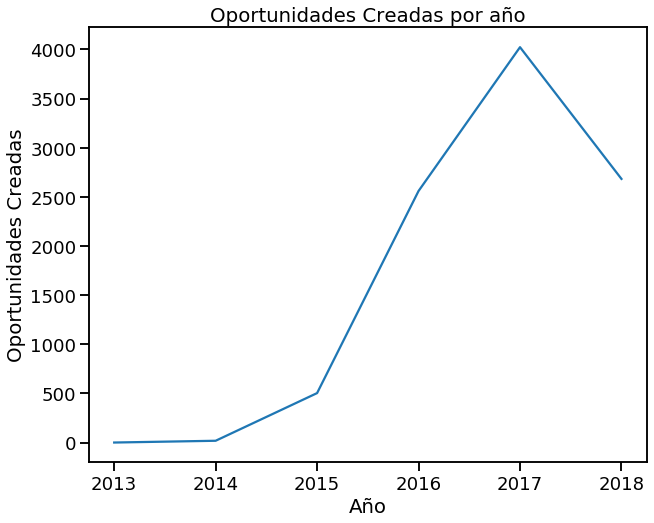

In [91]:
df.Opportunity_Created_Date = pd.to_datetime(df.Opportunity_Created_Date, errors='coerce')
df['Year_Created'] = df.Opportunity_Created_Date.dt.year
opp_per_year = df.groupby('Year_Created').agg({'Opportunity_ID':'nunique'}).reset_index()
opp_per_year.columns = ['Year', 'Opportunities_Created']

plt.figure(figsize=(10,8))
plt.plot(opp_per_year.Year, opp_per_year.Opportunities_Created)
plt.title('Oportunidades Creadas por año')
plt.xlabel('Año')
plt.ylabel('Oportunidades Creadas')
plt.show()

Podemos ver cómo fue aumentando la cantidad de oportunidades a lo largo de los años, alcanzando su pico en el año 2017. 

Miremos un poco más en detalle cómo se distribuyen las oportunidades.

In [127]:
df['Opportunity_Created_Date'] = pd.to_datetime(df['Opportunity_Created_Date'], errors='coerce')

df['Year_Created'] = df['Opportunity_Created_Date'].dt.year
df['Month_Created'] = df['Opportunity_Created_Date'].dt.month
year_month = df.groupby(['Year_Created', 'Month_Created']).agg({'Opportunity_ID':'nunique'}).unstack(1).fillna(0)
#display(year_month)
year_month.columns = year_month.columns.get_level_values(1)
year_month

Month_Created,1,2,3,4,5,6,7,8,9,10,11,12
Year_Created,,,,,,,,,,,,
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2014,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,3.0,7.0,0.0,2.0
2015,4.0,6.0,9.0,42.0,9.0,19.0,35.0,18.0,103.0,47.0,71.0,141.0
2016,167.0,156.0,165.0,137.0,166.0,171.0,242.0,213.0,227.0,267.0,234.0,415.0
2017,265.0,319.0,435.0,359.0,474.0,483.0,305.0,289.0,304.0,320.0,211.0,259.0
2018,286.0,235.0,223.0,210.0,260.0,212.0,265.0,209.0,179.0,263.0,217.0,124.0


2013 y 2014 tienen muy pocos datos y muy alejados de los valores normales. Sacamos esas columnas para no embarrar el gráfico.

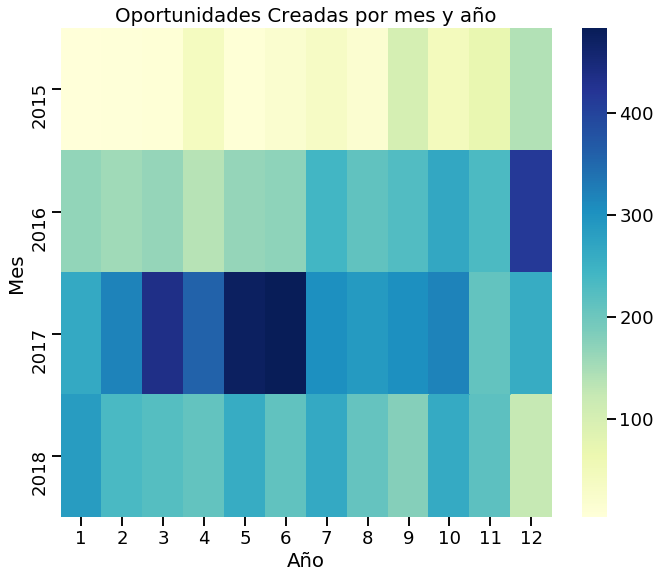

In [130]:
year_month = year_month.iloc[2:, :]

fig, ax = plt.subplots(figsize=(11, 9))
plt.title('Oportunidades Creadas por mes y año')
sns.heatmap(year_month, cmap='YlGnBu')
ax.set_xlabel('Año')
ax.set_ylabel('Mes')
plt.show()

Se puede apreciar como fue aumentando a lo largo del tiempo la cantidad de oportunidades que se fueron presentando también. Un dato que se puede inferir de este gráfico que no se podía del anterior es que para cada año, hay mayor cantidad de oportunidades mientras mas cerca nos encontramos de mitad de año. Esto tiene sentido ya que como se verá más abajo, las regiones a las que la empresa vende sus productos son en su gran mayoría del hemisferio norte. En otras palabras, en el hemisferio norte la primera mitad del año es la que más calor hace ya que se encuentran en primavera/verano. En el gráfico se puede ver como hay más ventas un mes antes de que comience el verano, esto puede ser consecuencia de que los compradores se están preparando para combatir el calor.

Veamos también cómo fue cambiando la cantidad de oportunidades que fueron aprobadas y desaprobadas a lo largo de los años.

In [93]:
opp_per_stage_per_year = df.groupby(['Year_Created', 'Stage']).agg({'Opportunity_ID':'nunique'}).unstack().reset_index()
display(opp_per_stage_per_year)
opp_per_stage_per_year.columns = ['Year', 'Closed Lost', 'Closed Won', 'a', 'b', 'c']
opp_per_stage_per_year.drop(columns = ['a', 'b', 'c'], inplace=True)
opp_per_stage_per_year.fillna(0, inplace=True)

Year_Created Opportunity_ID                                  \
Stage                 Closed Lost Closed Won Negotiation Proposal   
0             2013            1.0        NaN         NaN      NaN   
1             2014           16.0        3.0         NaN      NaN   
2             2015          380.0      124.0         NaN      NaN   
3             2016         1385.0     1175.0         NaN      NaN   
4             2017         1787.0     2235.0         NaN      1.0   
5             2018         1131.0     1503.0        11.0     29.0   

                     
Stage Qualification  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
5               9.0

In [94]:
opp_per_stage_per_year

,Year,Closed Lost,Closed Won
0,2013,1.0,0.0
1,2014,16.0,3.0
2,2015,380.0,124.0
3,2016,1385.0,1175.0
4,2017,1787.0,2235.0
5,2018,1131.0,1503.0


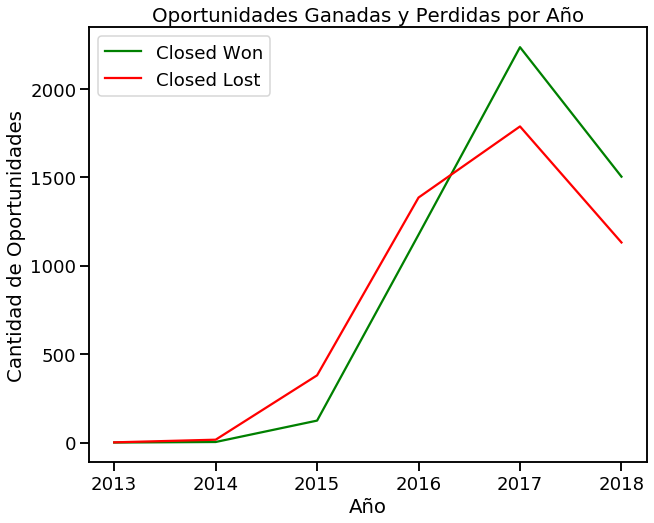

In [95]:
plt.figure(figsize=(10,8))
plt.plot(opp_per_stage_per_year.Year, opp_per_stage_per_year['Closed Won'], label='Closed Won', color = 'green')
plt.plot(opp_per_stage_per_year.Year, opp_per_stage_per_year['Closed Lost'], label='Closed Lost', color = 'red')
plt.title('Oportunidades Ganadas y Perdidas por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Oportunidades')
plt.legend()
plt.show()

Podemos ver cómo la empresa fue mejorando año a año su relación entre las oportunidades aprobadas y las desaprobadas. Esto puede ser consecuencia de varios factores: la empresa se fue ganando un nombre, puede ser que haya ganado clientes fieles que compren sus productos, quizá mejoró el staff que se encargaba de las ventas y ahora ésta gente está más capacitada para vender, etc etc.

Veamos también qué regiones son las que más contribuyen a las oportunidades presentadas y cómo fue cambiando ésto a lo largo de los años.

In [96]:
opp_per_reg_year = df.groupby(['Year_Created', 'Region']).agg({'Opportunity_ID':'nunique'})
opp_per_reg_year = opp_per_reg_year.unstack().fillna(0).reset_index()
opp_per_reg_year

Year_Created Opportunity_ID                                    
Region                        APAC Americas    EMEA  Japan Middle East
0              2013            0.0      0.0     1.0    0.0         0.0
1              2014            8.0      7.0     4.0    0.0         0.0
2              2015           55.0    164.0   159.0  126.0         0.0
3              2016          533.0    521.0   847.0  644.0        15.0
4              2017          947.0   1071.0  1229.0  709.0        67.0
5              2018          523.0    682.0   991.0  420.0        67.0

In [97]:
opp_per_reg_year.columns=['Year', 'APAC', 'Americas', 'EMEA', 'Japan', 'Middle East']
opp_per_reg_year

,Year,APAC,Americas,EMEA,Japan,Middle East
0,2013,0.0,0.0,1.0,0.0,0.0
1,2014,8.0,7.0,4.0,0.0,0.0
2,2015,55.0,164.0,159.0,126.0,0.0
3,2016,533.0,521.0,847.0,644.0,15.0
4,2017,947.0,1071.0,1229.0,709.0,67.0
5,2018,523.0,682.0,991.0,420.0,67.0


EMEA se refiere a Europa, Medio Oriente (Middle East) y África, entonces sumamos los valores de la columna Middle East a EMEA.

In [98]:
opp_per_reg_year.EMEA = opp_per_reg_year.EMEA + opp_per_reg_year['Middle East']
opp_per_reg_year.drop(columns='Middle East')

,Year,APAC,Americas,EMEA,Japan
0,2013,0.0,0.0,1.0,0.0
1,2014,8.0,7.0,4.0,0.0
2,2015,55.0,164.0,159.0,126.0
3,2016,533.0,521.0,862.0,644.0
4,2017,947.0,1071.0,1296.0,709.0
5,2018,523.0,682.0,1058.0,420.0


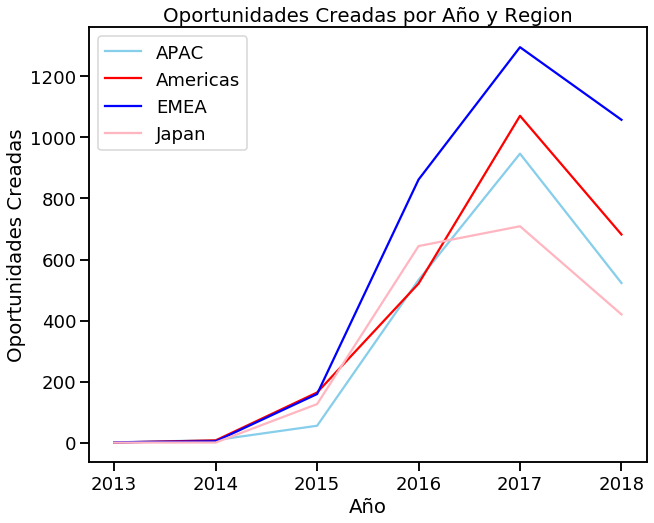

In [99]:
plt.figure(figsize=(10,8))
plt.plot(opp_per_reg_year.Year, opp_per_reg_year.APAC, label='APAC', color = 'skyblue')
plt.plot(opp_per_reg_year.Year, opp_per_reg_year.Americas, label='Americas', color='Red')
plt.plot(opp_per_reg_year.Year, opp_per_reg_year.EMEA, label='EMEA', color='blue')
plt.plot(opp_per_reg_year.Year, opp_per_reg_year.Japan, label='Japan', color='lightpink')
plt.title('Oportunidades Creadas por Año y Region')
plt.xlabel('Año')
plt.ylabel('Oportunidades Creadas')
plt.legend()
plt.show()

Vemos que la cantidad de oportunidades de cada región está muy relacionada con la cantidad de personas que viven en cada una, qué tanto calor hace en las mismas y qué tan desarrolladas están. Por eso vemos como las dos regiones que más oportunidades presentan son Norte America y EMEA.

In [100]:
df.drop(columns=['Year_Created'], inplace=True)

## Analizando los vendedores

Analizaremos cómo se distribuyen las oportunidades de la empresa entre los vendedores.

In [101]:
won_or_lost = df.loc[(df['Stage']=='Closed Won') | (df['Stage']=='Closed Lost')]
solo_una_oportunidad = won_or_lost.drop_duplicates(subset='Opportunity_ID')

owners = solo_una_oportunidad.groupby(['Opportunity_Owner', 'Stage']).agg({'Opportunity_ID':'count', 'Total_Amount_Sum_USD':'sum'}).reset_index()

owners['Total']= owners.groupby('Opportunity_Owner')['Opportunity_ID'].transform('sum')
total_oportunidades = solo_una_oportunidad.Opportunity_ID.count()
owners['Percentage_Participation']=owners.Total * 100 / total_oportunidades
owners_won = owners[owners.Stage == 'Closed Won'].copy()

owners_won.columns = ['Opportunity_Owner', 'Stage', 'Quantity Won', 'Dinero Obtenido (Millones USD)', 'Total Opportunities Owned', 'Percentage Owned']

owners_won['Average Won'] = owners_won['Quantity Won'] * 100/ owners_won['Total Opportunities Owned']
owners_won['Dinero Obtenido (Millones USD)'] = owners_won['Dinero Obtenido (Millones USD)']/1000000
owners_won

,Opportunity_Owner,Stage,Quantity Won,Dinero Obtenido (Millones USD),Total Opportunities Owned,Percentage Owned,Average Won
3,Person_Name_11,Closed Won,26,1.904933,71,0.728953,36.619718
5,Person_Name_12,Closed Won,2,42.698448,18,0.184805,11.111111
7,Person_Name_13,Closed Won,434,232.999889,755,7.751540,57.483444
9,Person_Name_14,Closed Won,25,3.329659,61,0.626283,40.983607
11,Person_Name_16,Closed Won,108,31.134805,397,4.075975,27.204030
13,Person_Name_18,Closed Won,325,97.508081,678,6.960986,47.935103
15,Person_Name_19,Closed Won,396,40.129614,408,4.188912,97.058824
17,Person_Name_2,Closed Won,44,4.151677,91,0.934292,48.351648
19,Person_Name_20,Closed Won,29,4.334993,42,0.431211,69.047619
21,Person_Name_22,Closed Won,9,1.271174,31,0.318275,29.032258


Text(0.5, 1.0, 'Distribución de oportunidades entre Vendedores y Oportunidades Ganadas')

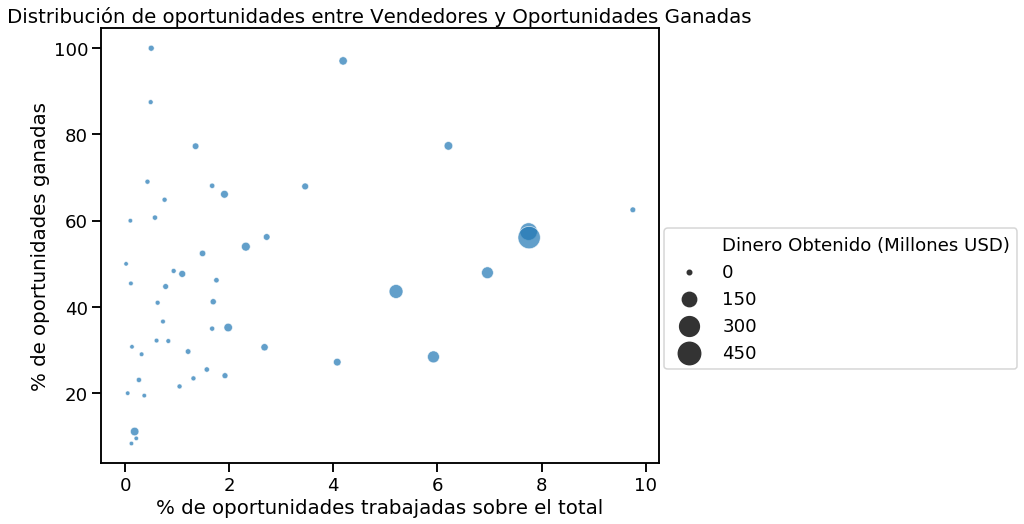

In [102]:
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(10,8))
sns.scatterplot(x='Percentage Owned', 
                y='Average Won',
                size='Dinero Obtenido (Millones USD)',            
                data=owners_won, 
                sizes=(20,500),
                alpha=0.7,
                )
plt.legend(bbox_to_anchor=(1.01, 0.54),  borderaxespad=0.)
plt.xlabel("% de oportunidades trabajadas sobre el total")
plt.ylabel("% de oportunidades ganadas")
plt.title('Distribución de oportunidades entre Vendedores y Oportunidades Ganadas')

Si trazaramos una línea vertical un poco antes del 2 y miramos hacia la derecha, vemos que hay 10 vendedores que concentran cerca del 60% de las oportunidades totales, y también podemos ver que las burbujas de esos vendedores son la mayoría más grandes que aquellas que están a la izquierda de la línea antes mencionada.

Por otro lado podemos observar que el porcentaje de de oportunidades ganadas tiende a estar entre 40 y 60%. Hay muy pocos vendedores con un ratio de oportunidades ganadas sobre totales mayor al 80%, y generalmente si lo tienen es porque no tienen demasiadas ventas intentadas y además porque no representan grandes cantidades de dinero. 

Vamos a mirar más en detalle como se distribuyen en el mundo ese top 10 de vendedores y cómo se maneja en cada región.

In [103]:
top_10_owners = owners_won.nlargest(10, 'Total Opportunities Owned')
top_10_owners = top_10_owners.loc[:, ['Opportunity_Owner', 'Total Opportunities Owned']]
top_10_owners

,Opportunity_Owner,Total Opportunities Owned
71,Person_Name_50,950
100,Person_Name_8,756
7,Person_Name_13,755
13,Person_Name_18,678
34,Person_Name_32,605
31,Person_Name_3,577
49,Person_Name_4,507
15,Person_Name_19,408
11,Person_Name_16,397
94,Person_Name_64,337


In [104]:
owners_filtered = top_10_owners.merge(df, on='Opportunity_Owner')
owners_filtered = owners_filtered.loc[:, ['Opportunity_Owner', 'Region', 'Stage', 'Opportunity_ID']]
owners_filtered.drop_duplicates(subset='Opportunity_ID', inplace=True)
owners_filtered = owners_filtered.loc[(owners_filtered.Stage=='Closed Won')|(owners_filtered.Stage=='Closed Lost')]

owners_filtered

,Opportunity_Owner,Region,Stage,Opportunity_ID
0,Person_Name_50,Japan,Closed Lost,8
5,Person_Name_50,Japan,Closed Lost,9
10,Person_Name_50,Japan,Closed Lost,10
15,Person_Name_50,Japan,Closed Lost,13
21,Person_Name_50,Japan,Closed Lost,14
...,...,...,...,...
11087,Person_Name_64,Americas,Closed Won,10483
11088,Person_Name_64,Americas,Closed Won,10522
11089,Person_Name_64,Americas,Closed Won,10538
11091,Person_Name_64,Americas,Closed Won,10589


In [105]:
grouped = owners_filtered.groupby(['Opportunity_Owner', 'Stage', 'Region']).agg({'Opportunity_ID':'count'}).reset_index()
grouped.columns = ['source', 'Stage', 'target', 'value']
grouped

,source,Stage,target,value
0,Person_Name_13,Closed Lost,APAC,7
1,Person_Name_13,Closed Lost,Americas,2
2,Person_Name_13,Closed Lost,EMEA,312
3,Person_Name_13,Closed Won,EMEA,434
4,Person_Name_16,Closed Lost,EMEA,289
5,Person_Name_16,Closed Won,EMEA,108
6,Person_Name_18,Closed Lost,EMEA,352
7,Person_Name_18,Closed Lost,Japan,1
8,Person_Name_18,Closed Won,EMEA,325
9,Person_Name_19,Closed Lost,APAC,12


In [131]:
stage = Partition.Simple('Stage', grouped['Stage'].unique())

nodes = {
    'start': ProcessGroup(list(grouped['source'])),  
    'middle': Waypoint(stage),
    'end': ProcessGroup(list(grouped['target'])), 
}

ordering = [['start'], ['middle'], ['end']]

bundles = [Bundle('start', 'end', waypoints=['middle'])]

nodes['start'].partition = Partition.Simple('source', grouped['source'].unique())
nodes['end'].partition = Partition.Simple('target', 
                                        grouped['target'].unique())

sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition=stage)
#sdd
weave(sdd, grouped).to_widget()

AttributeError: 'LayeredGraph' object has no attribute 'node'